In [43]:
import numpy as np
import tensorflow as tf
import gym
from collections import deque
import random
import time
import pickle
import matplotlib.pyplot as plt

In [87]:
# PARAMETERS
REPLAY_BUFFER_SIZE = 50000
BATCH_SIZE = 32
STATE_SHAPE = 3
ACTION_NUMBER = 11
GAMMA = 0.99
EPSILON_DECAY_TIME = 400000
TRAIN_STARTING_POINT = 5000
TARGET_UPDATE_FREQ = 4000
MAX_STEP = 500000
EVALUATION_FREQ = 10000
EVALUATION_LENGTH = 5

In [85]:
## REPLAY BUFFER

class ReplayBuffer():
    def __init__(self):
        self.history = deque([], maxlen = REPLAY_BUFFER_SIZE)
    def update(self, state, action, reward, next_state, done):
        buffer = (state, action, reward, next_state, done)
        self.history.append(buffer)
        
    def sample_batch(self):
        batch = random.sample(self.history, BATCH_SIZE)
        return batch
    
        

In [41]:
class Agent():
    def __init__(self):
        self.epsilon = 1.0
        self.epsilon_eval= 0.05
        self.final_epsilon = 0.1
        self.epsilon_decay = (1.0 - self.final_epsilon) / (EPSILON_DECAY_TIME - REPLAY_BUFFER_SIZE)
        self.replay = ReplayBuffer()
        self.input_state = tf.placeholder(shape=(None, STATE_SHAPE), dtype=tf.float32)
        self.actions = tf.placeholder(shape=(None,), dtype=tf.int32)
        with tf.variable_scope('online'):
            self.online_q_values = self._build_network()
            print('online build')
        with tf.variable_scope('target'):
            self.target_q_values = self._build_network()
            print('target build')
        self.online_parameters = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'online')
        self.target_parameters = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'target')
        
        self.target_values = tf.placeholder(shape=(None, ACTION_NUMBER), dtype=tf.float32)
        self.loss = tf.reduce_sum(tf.square(self.target_values - self.online_q_values))
     
        self.gradient = tf.gradients(self.loss, self.online_parameters)
        self.apply_grad = Optimizer.apply_gradients(zip(self.gradient, self.online_parameters))
        
        
        self.sync_ops = self._sync_network_op()
        
    def _build_network(self):       
        hidden_1 = tf.layers.dense(inputs = self.input_state, units = 64, activation=tf.nn.relu, use_bias=True, kernel_initializer=tf.contrib.layers.xavier_initializer())
        hidden_2 = tf.layers.dense(inputs = hidden_1, units = 64, activation=tf.nn.relu, use_bias=True, kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        q_value = tf.layers.dense(inputs = hidden_2, units = ACTION_NUMBER, use_bias=True, kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        return q_value
    def _sync_network_op(self):
        ops = []
        for online, target in zip(self.online_parameters, self.target_parameters):
            op = target.assign(online)
            ops.append(op)
        return ops

    def sync_network(self):
        for op in self.sync_ops:
            sess.run(op)        
        
    def train(self):
        batches = self.replay.sample_batch()
        states, actions, rewards, next_states, dones = [],[],[],[],[]
        
        for batch in batches:
            states.append(batch[0])
            actions.append(batch[1])
            rewards.append(batch[2])
            next_states.append(batch[3])
            dones.append(batch[4])
        target_values = sess.run(self.online_q_values, feed_dict={self.input_state:states})
        target_q_values = sess.run(self.target_q_values, feed_dict={self.input_state: next_states})
        for i in range(BATCH_SIZE):
            if dones[i]==False:
                target_values[i,actions[i]] = rewards[i] + GAMMA * np.max(target_q_values[i])
            elif dones[i]==True:
                target_values[i,actions[i]] = rewards[i]
            else:
                print('wrong')
        
    
        loss, _ = sess.run([self.loss, self.apply_grad], feed_dict={self.target_values:target_values, self.input_state:states})
        
        return loss


    def epsilon_decayer(self):
        if len(self.replay.history)==REPLAY_BUFFER_SIZE and self.epsilon>self.final_epsilon:
            self.epsilon -= self.epsilon_decay
            
    
    def action_sample(self, state, evaluate=False):
        if evaluate==False: epsilon=self.epsilon
        else: epsilon=self.epsilon_eval
        if random.random()>epsilon:
            q_values = sess.run(self.online_q_values, feed_dict={self.input_state:state})
            action = np.argmax(q_values[0])
        else:
            action = random.randint(0, ACTION_NUMBER-1)
            q_values=[[0]]
            
        
        return action, q_values[0]
    
    def evaluate(self, env):
        print('Evaluation Start')

        scores = []
        for episode in range(EVALUATION_LENGTH):
            score=0
            state = env.reset()
            while True:
                action, _ = self.action_sample([state], evaluate=True)
                normed_action = [-2.0 + action*4.0/(ACTION_NUMBER - 1.0)]
                next_state, reward, done, _ = env.step(normed_action)
                score += reward
                if done==True:
                    scores.append(score)
                    break
                state = next_state
        print('Evaluation End, mean score:', np.mean(scores))
        
        return np.mean(scores)
        
                
    

In [79]:
trial_num=4
tf.reset_default_graph()

sess =tf.Session()
SCORES = []
Qvalues = []
EVAL_SCORES = []

Optimizer = tf.train.AdamOptimizer(learning_rate = 1e-4)
agent=Agent()
sess.run(tf.global_variables_initializer())
env = gym.make('Pendulum-v0')
eval_env = gym.make('Pendulum-v0')

step_count = 0
episode_count = 0
score_deque = deque([], maxlen=10)
rendering=False
loss = None
while True:
    if episode_count%500==0:
        rendering=True
    else:
        rendering=False
    state = env.reset()
    episode_count += 1
    score = 0
    qvalues = []

    while True:
        action, q_values = agent.action_sample([state])

        qvalues.append(np.max(q_values[0]))
        normed_action = [-2.0 + action*4.0/(ACTION_NUMBER - 1.0)]
        step_count += 1

        next_state, reward, done, _ = env.step(normed_action)
        if rendering==True:
            env.render()
            time.sleep(0.05)

        score += reward
        agent.replay.update(state,action,reward,next_state,done)
        state = next_state

        if len(agent.replay.history)>TRAIN_STARTING_POINT:
            loss = agent.train()
            agent.epsilon_decayer()
        if step_count%TARGET_UPDATE_FREQ==0:
            agent.sync_network()            
        
        if step_count%EVALUATION_FREQ==0:
            eval_score = agent.evaluate(eval_env)
            EVAL_SCORES.append(eval_score)
        
        if done:
            score_deque.append(score)
            if episode_count%10==0:
                print('DONE EPISODE:', episode_count, 'reward:', np.mean(score_deque), 'step:', step_count, 'epsilon:', agent.epsilon, 'loss:', loss, 'action:', normed_action, 'q:', q_values)
            if rendering==True:
                rendering=False
                env.close()
            break
    SCORES.append(score)
    Qvalues.append(np.mean(qvalues))
    if step_count>MAX_STEP:
        score_deque.append(score)
        print('MAX STEPS')
        break
        
with open('./pendulum_eval_score_' + str(trial_num) + '.pickle', 'wb') as f:
    pickle.dump(EVAL_SCORES, f)

        

        



online build
target build
DONE EPISODE: 10 reward: -980.4567740257922 step: 2000 epsilon: 1.0 loss: None action: [-1.6] q: [0]
DONE EPISODE: 20 reward: -1349.4260538140056 step: 4000 epsilon: 1.0 loss: None action: [1.2000000000000002] q: [0]
DONE EPISODE: 30 reward: -1204.795060799544 step: 6000 epsilon: 1.0 loss: 197.37936 action: [-2.0] q: [0]
DONE EPISODE: 40 reward: -1292.6515316843934 step: 8000 epsilon: 1.0 loss: 29.590227 action: [2.0] q: [0]
Evaluation Start
Evaluation End, mean score: -1563.3916730699075
DONE EPISODE: 50 reward: -1290.0000697785722 step: 10000 epsilon: 1.0 loss: 16.470428 action: [1.6] q: [0]
DONE EPISODE: 60 reward: -1447.0045107647863 step: 12000 epsilon: 1.0 loss: 7.1882463 action: [1.6] q: [0]
DONE EPISODE: 70 reward: -1300.516124367386 step: 14000 epsilon: 1.0 loss: 10.873401 action: [-1.2] q: [0]
DONE EPISODE: 80 reward: -1298.8131261839258 step: 16000 epsilon: 1.0 loss: 4.0924315 action: [0.3999999999999999] q: [0]
DONE EPISODE: 90 reward: -1151.570526

DONE EPISODE: 190 reward: -1251.3031816665457 step: 38000 epsilon: 1.0 loss: 26.845863 action: [2.0] q: [0]
Evaluation Start
Evaluation End, mean score: -977.2478290074174
DONE EPISODE: 200 reward: -1259.1137611042855 step: 40000 epsilon: 1.0 loss: 19.886517 action: [1.6] q: [0]
DONE EPISODE: 210 reward: -1169.3747201182027 step: 42000 epsilon: 1.0 loss: 19.574818 action: [-2.0] q: [0]
DONE EPISODE: 220 reward: -1143.844578213892 step: 44000 epsilon: 1.0 loss: 50.447403 action: [1.6] q: [0]
DONE EPISODE: 230 reward: -1362.5343539632047 step: 46000 epsilon: 1.0 loss: 71.90036 action: [0.0] q: [0]
DONE EPISODE: 240 reward: -1231.661771093183 step: 48000 epsilon: 1.0 loss: 2855.6394 action: [0.3999999999999999] q: [0]
Evaluation Start
Evaluation End, mean score: -1071.3618628619347
DONE EPISODE: 250 reward: -1286.614364962869 step: 50000 epsilon: 0.9999974285714286 loss: 95.89625 action: [0.0] q: [0]
DONE EPISODE: 260 reward: -1182.2869566953375 step: 52000 epsilon: 0.9948545714286139 los

DONE EPISODE: 710 reward: -937.8646490984536 step: 142000 epsilon: 0.7634260000019522 loss: 12040.806 action: [1.6] q: [0]
DONE EPISODE: 720 reward: -977.4885400159741 step: 144000 epsilon: 0.7582831428591374 loss: 307.92337 action: [0.0] q: [0]
DONE EPISODE: 730 reward: -932.7677855701019 step: 146000 epsilon: 0.7531402857163227 loss: 180.92361 action: [-2.0] q: [-120.046196 -121.47334  -120.20054  -120.77123  -121.589096 -121.72254
 -121.371864 -121.504234 -120.820854 -120.956375 -121.47655 ]
DONE EPISODE: 740 reward: -955.8435681039928 step: 148000 epsilon: 0.747997428573508 loss: 143.42397 action: [1.6] q: [-92.568054 -92.770485 -92.065956 -91.864044 -91.26128  -90.65246
 -90.12267  -89.575806 -87.74696  -87.16662  -87.377846]
Evaluation Start
Evaluation End, mean score: -190.16947766867935
DONE EPISODE: 750 reward: -919.9229481903207 step: 150000 epsilon: 0.7428545714306933 loss: 175.60439 action: [-1.6] q: [0]
DONE EPISODE: 760 reward: -1013.5065687393104 step: 152000 epsilon: 0.

DONE EPISODE: 1190 reward: -568.9833183113581 step: 238000 epsilon: 0.5165688571468463 loss: 372.62018 action: [0.3999999999999999] q: [0]
Evaluation Start
Evaluation End, mean score: -118.74973419970402
DONE EPISODE: 1200 reward: -550.8227493223434 step: 240000 epsilon: 0.5114260000040316 loss: 299.43887 action: [0.3999999999999999] q: [0]
DONE EPISODE: 1210 reward: -570.4999534397373 step: 242000 epsilon: 0.5062831428612169 loss: 4551.272 action: [0.3999999999999999] q: [0]
DONE EPISODE: 1220 reward: -546.8844545523341 step: 244000 epsilon: 0.5011402857184022 loss: 1165.7301 action: [1.2000000000000002] q: [-33.031937 -35.352802 -32.710026 -32.271595 -31.114494 -30.158731
 -30.17122  -29.862164 -28.305185 -29.365986 -28.914572]
DONE EPISODE: 1230 reward: -425.5153366760716 step: 246000 epsilon: 0.4959974285755875 loss: 376.5675 action: [1.2000000000000002] q: [-29.062695 -32.07826  -29.367977 -29.234394 -28.487743 -27.936954
 -28.354748 -28.056036 -27.366436 -27.78903  -27.806826]
DO

DONE EPISODE: 1560 reward: -367.77626545174155 step: 312000 epsilon: 0.3262831428627022 loss: 362.0715 action: [1.2000000000000002] q: [-12.325175  -11.13454   -10.487428   -9.434895   -9.016539   -8.757685
  -8.396348   -7.9745564  -7.598117   -8.057368   -8.382342 ]
DONE EPISODE: 1570 reward: -342.88846443153346 step: 314000 epsilon: 0.3211402857198875 loss: 256.903 action: [1.6] q: [0]
DONE EPISODE: 1580 reward: -326.71343266701945 step: 316000 epsilon: 0.3159974285770728 loss: 448.08258 action: [2.0] q: [-47.67572  -43.44996  -38.683502 -35.60421  -31.363268 -27.613317
 -24.070944 -21.41684  -16.92184  -16.194666  -8.847649]
DONE EPISODE: 1590 reward: -410.6150557519669 step: 318000 epsilon: 0.3108545714342581 loss: 580.4149 action: [-2.0] q: [0]
Evaluation Start
Evaluation End, mean score: -144.25225444409492
DONE EPISODE: 1600 reward: -307.71300224447094 step: 320000 epsilon: 0.3057117142914434 loss: 480.02667 action: [0.3999999999999999] q: [-9.405392  -8.792209  -7.919698  -7.7

Evaluation Start
Evaluation End, mean score: -80.15619489877545
DONE EPISODE: 1900 reward: -244.2647675687224 step: 380000 epsilon: 0.15142600000593823 loss: 110.5238 action: [0.0] q: [-3.3789215  -3.0180612  -2.078789   -1.9780495  -1.1943942  -0.6535103
 -0.7431948  -0.7827184  -0.75483155 -1.3128207  -1.7283335 ]
DONE EPISODE: 1910 reward: -224.86189992159962 step: 382000 epsilon: 0.146283142863068 loss: 312.66254 action: [0.3999999999999999] q: [1.6041511  1.8941798  2.3766685  2.6777484  2.6580765  2.6502855
 2.7553747  2.489505   2.6711807  2.2400863  0.24562024]
DONE EPISODE: 1920 reward: -324.84032089064533 step: 384000 epsilon: 0.1411402857201978 loss: 222.24994 action: [0.7999999999999998] q: [-0.27934074  0.34647644  1.6054912   1.99652     2.3183975   2.5519009
  2.631122    3.003826    2.9193459   2.8723955   1.9415936 ]
DONE EPISODE: 1930 reward: -213.61156502716813 step: 386000 epsilon: 0.13599742857732758 loss: 88.76692 action: [2.0] q: [-10.038965    -8.452625    -7.09

DONE EPISODE: 2220 reward: -158.76875883182353 step: 444000 epsilon: 0.09999742857723606 loss: 57.05952 action: [1.2000000000000002] q: [1.8727707 2.9734297 4.002194  4.950953  5.037006  5.4016647 5.815142
 5.869127  6.064716  6.0173793 5.4282923]
DONE EPISODE: 2230 reward: -211.38019571586602 step: 446000 epsilon: 0.09999742857723606 loss: 355.52853 action: [1.6] q: [3.0403576 3.9989705 4.934718  5.336644  5.5644016 5.9690933 6.201616
 6.16664   6.305435  6.3180223 5.3056445]
DONE EPISODE: 2240 reward: -186.12615019685146 step: 448000 epsilon: 0.09999742857723606 loss: 190.02725 action: [0.0] q: [0]
Evaluation Start
Evaluation End, mean score: -153.46996548078786
DONE EPISODE: 2250 reward: -225.7078337838895 step: 450000 epsilon: 0.09999742857723606 loss: 427.4615 action: [0.3999999999999999] q: [0]
DONE EPISODE: 2260 reward: -241.2163268563758 step: 452000 epsilon: 0.09999742857723606 loss: 77.882576 action: [2.0] q: [-3.7193723  -2.3906617  -1.2534246   0.32219985  1.8097942   2.434

In [29]:
# env.close()

[-1472.31102582 -1364.27989615 -1006.65926563  -794.98841765
  -470.56693036  -564.48291079 -1252.3306112   -934.84100969
  -925.78634221  -741.80645306  -780.99566808  -911.03934021
  -830.72275699  -652.901882     -34.70781711  -229.64590673
  -174.43288564  -103.72279565  -126.23997013  -137.79575752
   -70.23371941   -91.54688444  -163.50533555   -74.69643844
  -106.96212608  -112.43213282  -148.68445714  -115.66614398
  -122.32582522  -116.53574203  -108.15517557  -114.87492453
  -103.98925741  -162.63630474  -159.82277145   -99.35876549
  -110.288826     -91.76367485  -137.29482203  -119.19005852
  -122.58169712  -100.29478319  -148.49695449  -146.20993194
  -150.04304895  -134.51846899  -105.58452363  -102.9741738
  -113.72159925  -156.10054528]


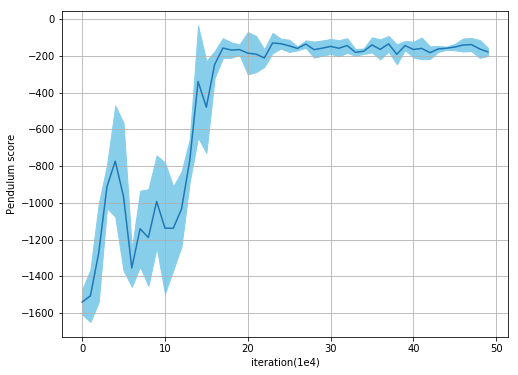

In [84]:
data = []
for i in range(5):
    with open('./pendulum_eval_score_' + str(i) + '.pickle', 'rb') as f:
        a = pickle.load(f)
        data.append(a)

result = np.mean(data, axis=0)
data = np.array(data)
var = []
for i in range(len(result)):
    var.append(np.sqrt(np.var(data[:,i])))
for i in range(len(result)):
    var1 = result + var
    var2 = result - var
    
plt.figure(figsize=(8,6))
plt.plot(result)
plt.fill_between(range(len(result)), var2, var1, color='skyblue')
plt.xlabel('iteration(1e4)')
plt.ylabel('Pendulum score')
plt.grid()
# print(var1)

